This is the second part of training a model for facial emotion classification. In the [first part](https://www.kaggle.com/code/harshit1234g/facial-emotion-classification) I tried several CNN architectures like VGGNet, ResNet, etc and trained them myself. In this part I'll use pretrained keras models and transfer learning to make better models.

In [1]:
import tensorflow as tf

## Loading Dataset
[Dataset Link](https://www.kaggle.com/datasets/msambare/fer2013)

In [2]:
train_path = r'/kaggle/input/fer2013/train'
test_path = r'/kaggle/input/fer2013/test'
CLASS_NAMES = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
IMG_SHAPE = (48, 48)

In [3]:
train_dataset, validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(   # it is optimized for large dataset
    train_path,
    label_mode= 'categorical',
    color_mode= 'rgb',     # because VGG Net (pretrained) needs data with 3 color channels
    class_names= CLASS_NAMES,
    shuffle= True,
    seed= 42,
    validation_split= 0.1,
    subset= 'both',
    image_size= IMG_SHAPE
)
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    label_mode= 'categorical',
    color_mode= 'rgb',
    class_names= CLASS_NAMES,
    shuffle= True,
    seed= 42,
    image_size= IMG_SHAPE
)

Found 28709 files belonging to 7 classes.
Using 25839 files for training.
Using 2870 files for validation.
Found 7178 files belonging to 7 classes.


## Data Augmentation

In [4]:
# using this because it is GPU accelerated
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode= 'horizontal'),
    tf.keras.layers.RandomRotation(factor= 0.1),    # [-10% * 2pi, 10% * 2pi]
    tf.keras.layers.RandomBrightness(factor= 0.1)   # only slightly darken or brighten the image
])


def augment_data(image: tf.Tensor, label: tf.Tensor) -> tuple[tf.Tensor, ...]:
    aug_img = data_augmentation(image)
    return aug_img, label


# generating augmented images
augmented_dataset = train_dataset.map(augment_data)

## Dataset Preparation

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = (
    train_dataset
    .concatenate(augmented_dataset)    # concatenating both train and augmented datasets
    .shuffle(buffer_size= 100)         # shuffling so that one batch will have both augmented and normal images
    .prefetch(buffer_size= AUTOTUNE)   # prefetching to making training faster
)
validation_dataset = validation_dataset.prefetch(buffer_size= AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size= AUTOTUNE)

## Using Pretrained Models from Keras for Transfer Learning
**Transfer Learning:**
- A technique to reuse models trained on large dataset (fully or partially) for a related task.
- We fine-tune a pretrained model for our specific task.
- The lower layers capture general image features like edges, textures and shape.
- Upper layers capture more specific details related to dataset.
- Reuses the lower layers and modify or replaces upper layers for our task.

For more details checkout [Transfer learning and fine-tuning](https://www.tensorflow.org/tutorials/images/transfer_learning).

### 1. [VGG-19](https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG19)

In [6]:
INPUT_SHAPE = IMG_SHAPE + (3,)        # (48, 48, 3)

vgg_19_base_model = tf.keras.applications.VGG19(
    include_top= False,               # do not include top 3 fully conneted layers
    weights= 'imagenet', 
    input_shape= INPUT_SHAPE
)

for layer in vgg_19_base_model.layers[:-4]:
    layer.trainable = False

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [7]:
vgg_19_base_model.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 48, 48, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 6, 6, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 3, 3, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 3, 3, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 12,944,960 (49.38 MB)

In [8]:
inputs = tf.keras.layers.Input(shape= INPUT_SHAPE)
x = tf.keras.applications.vgg19.preprocess_input(inputs)
x = vgg_19_base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
output = tf.keras.layers.Dense(len(CLASS_NAMES), activation= 'softmax')(x)

model = tf.keras.Model(inputs, output)

In [9]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 48, 48, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 48, 48)         │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_1 (GetItem)      │ (None, 48, 48)         │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item_2 (GetItem)      │ (None, 48, 48)         │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stack (Stack)             │ (None, 48, 48, 3)      │              0 │ get_item[0][0],        │
│                           │                        │                │ get_item_1[0][0],      │
│                           │                        │                │ get_item_2[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 48, 48, 3)      │              0 │ stack[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vgg19 (Functional)        │ (None, 1, 1, 512)      │     20,024,384 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 512)            │              0 │ vgg19[0][0]            │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 7)              │          3,591 │ global_average_poolin… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 20,027,975 (76.40 MB)

 Trainable params: 7,083,015 (27.02 MB)

 Non-trainable params: 12,944,960 (49.38 MB)

In [10]:
model.trainable_variables

[<KerasVariable shape=(3, 3, 512, 512), dtype=float32, path=block5_conv2/kernel>,
 <KerasVariable shape=(512,), dtype=float32, path=block5_conv2/bias>,
 <KerasVariable shape=(3, 3, 512, 512), dtype=float32, path=block5_conv3/kernel>,
 <KerasVariable shape=(512,), dtype=float32, path=block5_conv3/bias>,
 <KerasVariable shape=(3, 3, 512, 512), dtype=float32, path=block5_conv4/kernel>,
 <KerasVariable shape=(512,), dtype=float32, path=block5_conv4/bias>,
 <KerasVariable shape=(512, 7), dtype=float32, path=dense/kernel>,
 <KerasVariable shape=(7,), dtype=float32, path=dense/bias>]

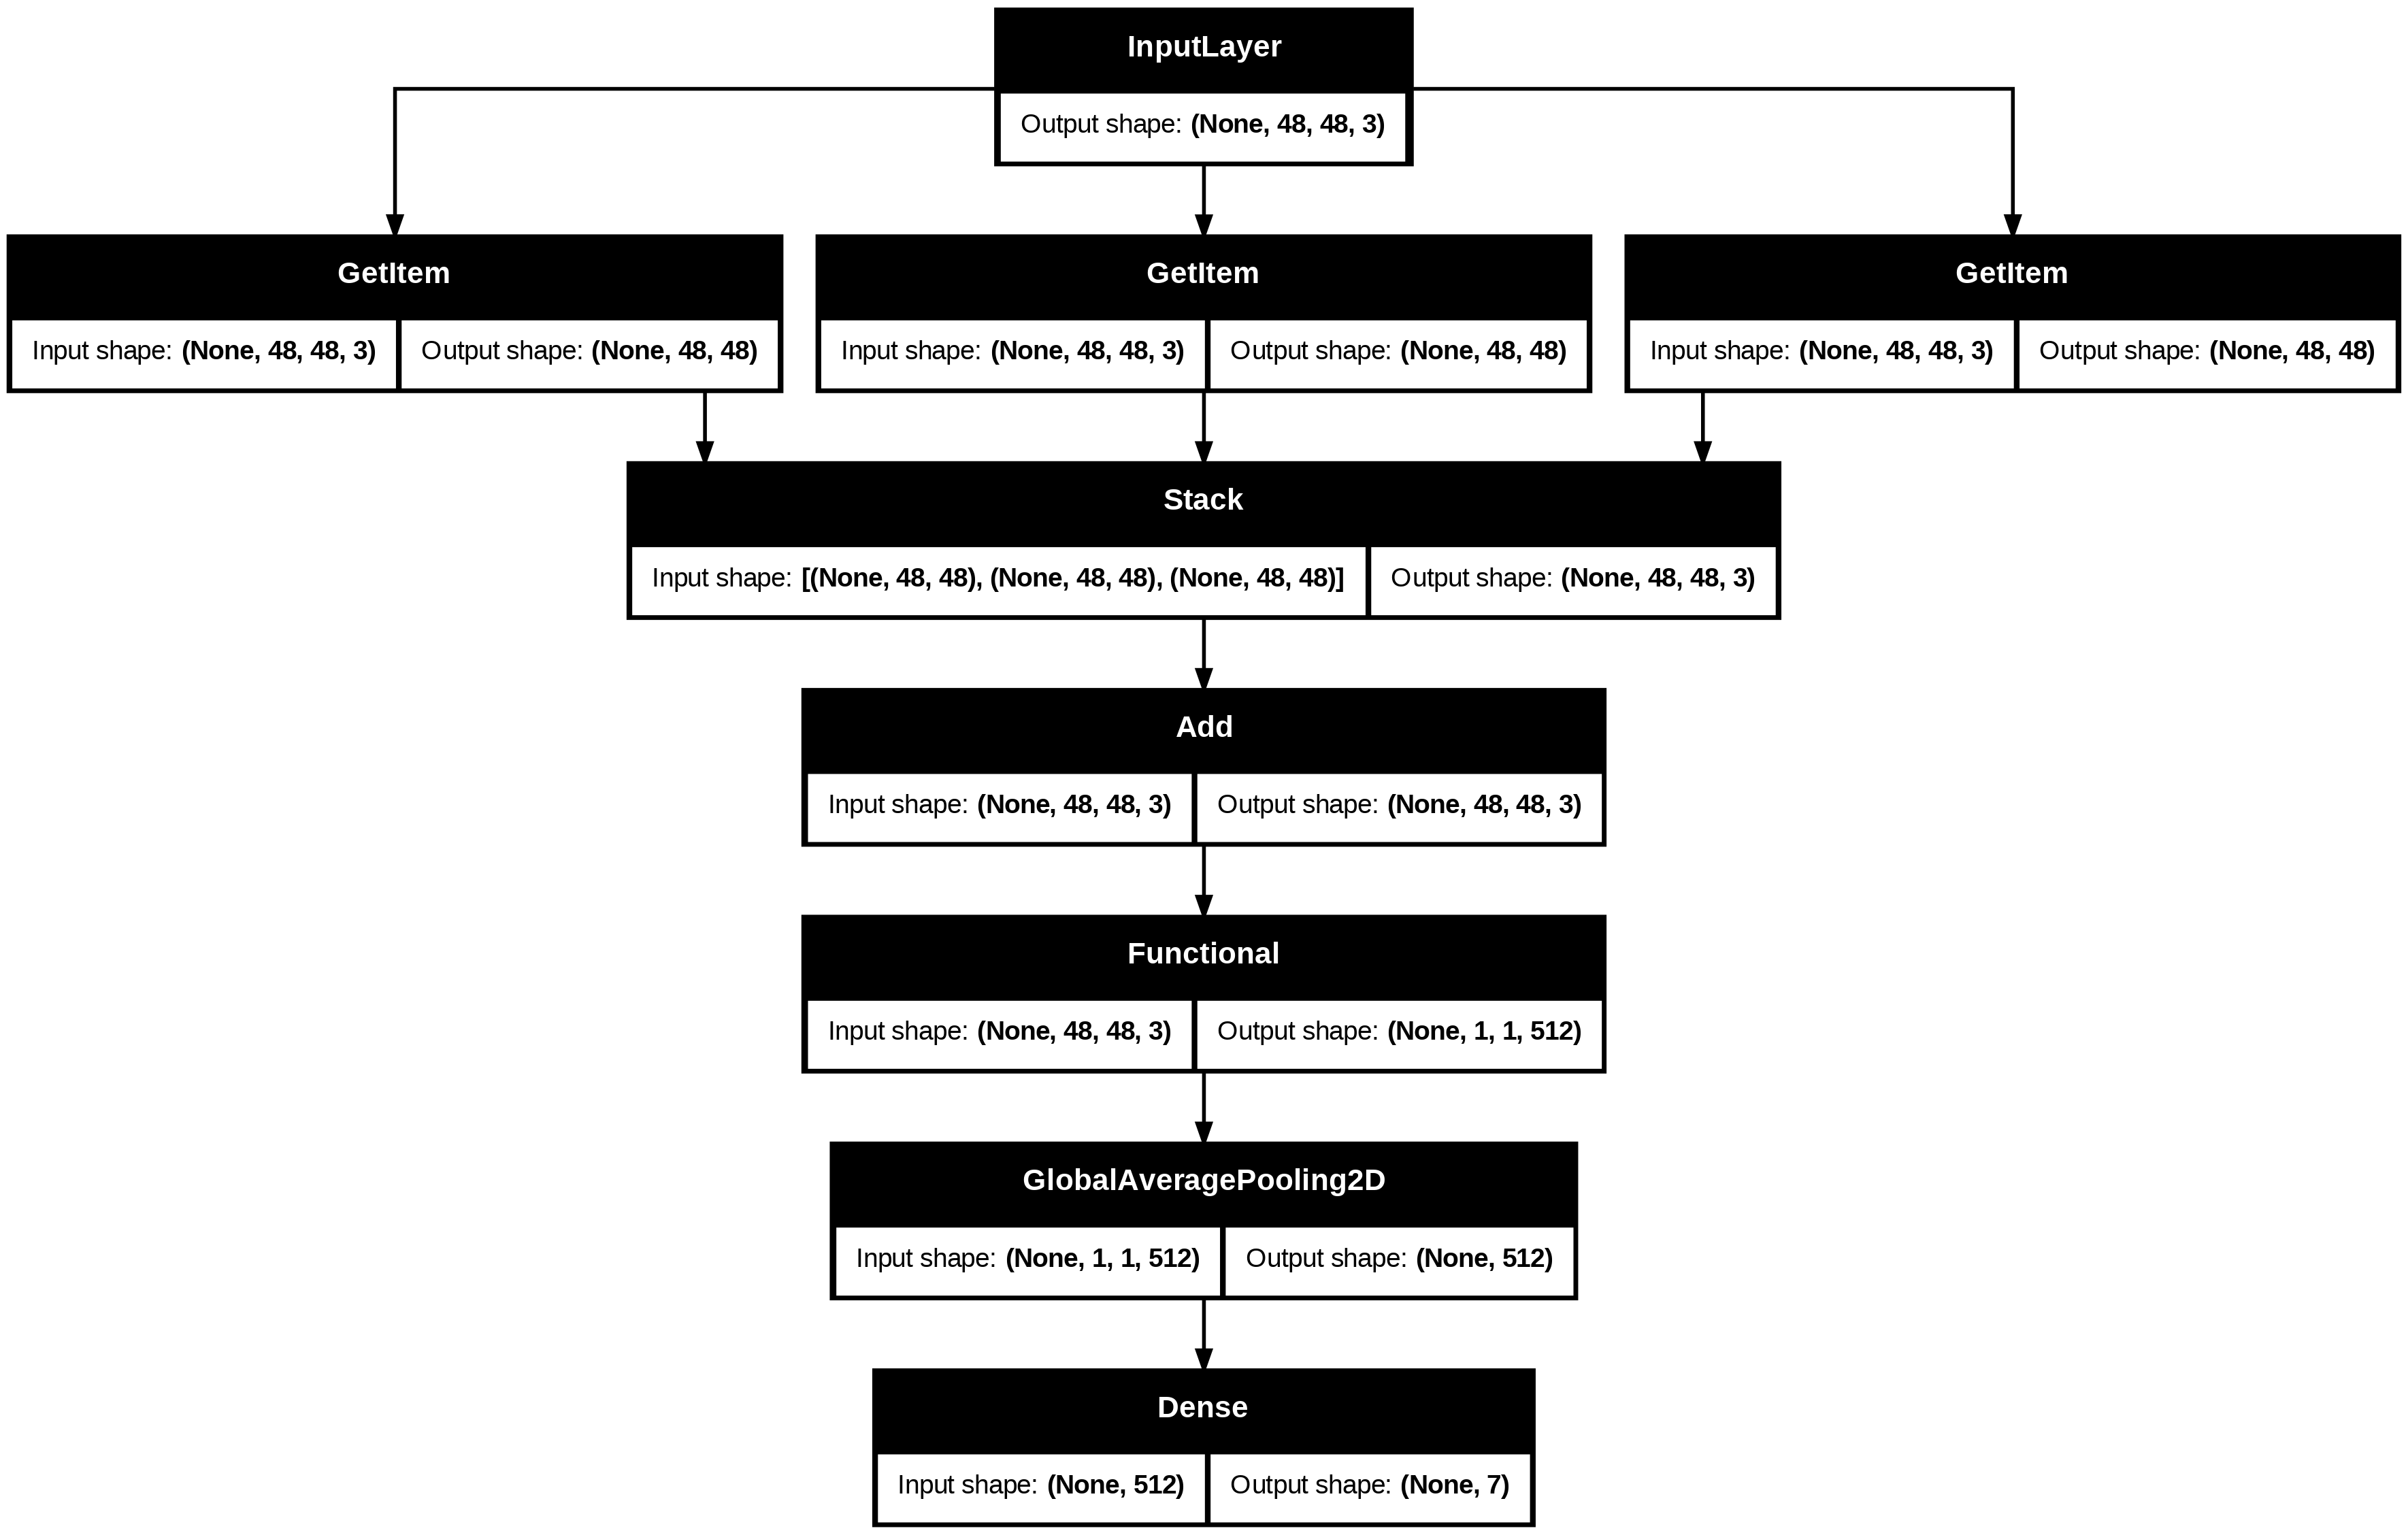

In [11]:
tf.keras.utils.plot_model(model, show_shapes= True)

In [12]:
def create_callbacks(name: str, *, es_patience: int = 5, lr_patience: int = 3) -> list[tf.keras.callbacks.Callback]:
    tensorboard_cb = tf.keras.callbacks.TensorBoard(f'/kaggle/working/logs/{name}')
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        patience= es_patience, 
        restore_best_weights= True
    )
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        f'{name}.weights.h5', 
        save_weights_only= True,
        save_best_only= True
    )
    lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(factor= 0.5, patience= lr_patience)
    return [tensorboard_cb, early_stopping, checkpoint_cb, lr_schedule]

In [13]:
model.compile(
    loss= 'categorical_crossentropy',
    optimizer= tf.keras.optimizers.Adam(learning_rate= 1e-5),
    metrics= ['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(name= 'top_k')]
)

In [14]:
history = model.fit(
    train_dataset,
    epochs= 100,
    validation_data= validation_dataset,
    callbacks= create_callbacks(name= 'vgg_19_tl', es_patience= 10)
)

Epoch 1/100
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 53s 27ms/step - accuracy: 0.2383 - loss: 3.4356 - top_k: 0.8332 - val_accuracy: 0.3366 - val_loss: 1.7408 - val_top_k: 0.8871 - learning_rate: 1.0000e-05
Epoch 2/100
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.3680 - loss: 1.6431 - top_k: 0.8993 - val_accuracy: 0.4537 - val_loss: 1.4659 - val_top_k: 0.9554 - learning_rate: 1.0000e-05
Epoch 3/100
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.4768 - loss: 1.3926 - top_k: 0.9583 - val_accuracy: 0.4892 - val_loss: 1.3891 - val_top_k: 0.9585 - learning_rate: 1.0000e-05
Epoch 4/100
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.5241 - loss: 1.2754 - top_k: 0.9671 - val_accuracy: 0.5010 - val_loss: 1.3415 - val_top_k: 0.9627 - learning_rate: 1.0000e-05
Epoch 5/100
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.5603 - loss: 1.1842 - top_k: 0.9737 - val_accuracy: 0.5073 - val_loss: 1.3202 - val_top_k: 0.9666 - learning_rate: 1.0000e-05
Epoch 6/100
161

In [16]:
test_loss, test_acc, top_k = model.evaluate(test_dataset)
print(f'{test_acc = :.2%}\n{test_loss = }\n{top_k = :.2%}')

225/225 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.5543 - loss: 1.2584 - top_k: 0.9704
test_acc = 55.31%
test_loss = 1.2475836277008057
top_k = 97.17%


In [19]:
import subprocess


def model_to_json_and_zip(model: tf.keras.Model, name: str) -> None:
    model_json = model.to_json()
    with open(f'{name}.json', 'w') as json_file:
        json_file.write(model_json)
        
    subprocess.run(["zip", "-r", "working_dir.zip", "/kaggle/working"], stdout= subprocess.DEVNULL)

In [20]:
model_to_json_and_zip(model, 'vgg_19_tl')

### 2. [ResNet-50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet50)

In [43]:
res_net_50_base_model = tf.keras.applications.ResNet50(
    include_top= False,
    weights= 'imagenet', 
    input_shape= INPUT_SHAPE
)

res_net_50_base_model.trainable = False

In [44]:
x = res_net_50_base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
output = tf.keras.layers.Dense(7, activation='softmax')(x)

model_res = tf.keras.Model(inputs= res_net_50_base_model.input, outputs= output)

In [45]:
model_res.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 48, 48, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 54, 54, 3)      │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 24, 24, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 24, 24, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 24, 24, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 26, 26, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 12, 12, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 12, 12, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 12, 12, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 12, 12, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 12, 12, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 12, 12, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 12, 12, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 12, 12, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 12, 12, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,153,863 (92.14 MB)

 Trainable params: 566,151 (2.16 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [46]:
model_res.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate= 1e-3),
    loss= 'categorical_crossentropy',
    metrics= ['accuracy']
)

In [47]:
model_res.fit(
    train_dataset,
    epochs= 5,
    validation_data= validation_dataset
)

Epoch 1/5
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 35s 16ms/step - accuracy: 0.3568 - loss: 1.6551 - val_accuracy: 0.3965 - val_loss: 1.5589
Epoch 2/5
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.4211 - loss: 1.4957 - val_accuracy: 0.4143 - val_loss: 1.5485
Epoch 3/5
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.4461 - loss: 1.4416 - val_accuracy: 0.4143 - val_loss: 1.5338
Epoch 4/5
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.4639 - loss: 1.3972 - val_accuracy: 0.4376 - val_loss: 1.4865
Epoch 5/5
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.4833 - loss: 1.3485 - val_accuracy: 0.4338 - val_loss: 1.4766


In [49]:
for layer in res_net_50_base_model.layers[:140]:
    layer.trainable = False
    
for layer in res_net_50_base_model.layers[140:]:  # unfreeze last 30-40 layers
    layer.trainable = True

In [50]:
model_res.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate= 1e-4),
    loss= 'categorical_crossentropy',
    metrics= ['accuracy']
)

In [51]:
history = model_res.fit(
    train_dataset,
    epochs= 10,
    validation_data= validation_dataset
)

Epoch 1/10
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 59s 26ms/step - accuracy: 0.4369 - loss: 1.4679 - val_accuracy: 0.4829 - val_loss: 1.3920
Epoch 2/10
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 32s 19ms/step - accuracy: 0.5485 - loss: 1.1986 - val_accuracy: 0.4892 - val_loss: 1.3556
Epoch 3/10
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 32s 19ms/step - accuracy: 0.6260 - loss: 1.0003 - val_accuracy: 0.5153 - val_loss: 1.3198
Epoch 4/10
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 32s 19ms/step - accuracy: 0.7026 - loss: 0.8068 - val_accuracy: 0.5258 - val_loss: 1.3402
Epoch 5/10
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 32s 19ms/step - accuracy: 0.7778 - loss: 0.6249 - val_accuracy: 0.5265 - val_loss: 1.3555
Epoch 6/10
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 32s 19ms/step - accuracy: 0.8299 - loss: 0.4903 - val_accuracy: 0.5390 - val_loss: 1.3476
Epoch 7/10
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 31s 19ms/step - accuracy: 0.8673 - loss: 0.3952 - val_accuracy: 0.5275 - val_loss: 1.4053
Epoch 8/10
1616/1616 ━━━━━━━━━━━━━━━━━━━━ 32s 19ms/step - accuracy: 0.8869 -

In [52]:
model_to_json_and_zip(model, 'res_net_50_tl')